<a href="https://colab.research.google.com/github/KGuruPrasad94/Craft_demo/blob/main/Craft_demo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Craft Demo - Intro

Goal: Optimize its policies and rules to accurately identify risky batches while minimizing user friction.

# **1. Import and Setup**

In [1]:
# Import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import scipy as sp
import os
import random
import requests
import zipfile
import io
from datetime import timedelta

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# setting display settings to view full df
pd.set_option('display.max_columns', None)

# **2. Data Load and Exploration**

In [2]:
# load data from github
merchants_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_application_data.csv"
transaction_url = "https://raw.githubusercontent.com/KGuruPrasad94/Craft_demo/main/Merchant_batch_performance_data.csv"

merchants_response = requests.get(merchants_url)
transaction_response = requests.get(transaction_url)

merchants_df = pd.read_csv(io.StringIO(merchants_response.text))
transaction_df = pd.read_csv(io.StringIO(transaction_response.text))

In [3]:
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017


In [4]:
# inspecting shape of merchants_df
print("Dataset Dimensions: {} x {}".format(merchants_df.shape[0], merchants_df.shape[1]))

Dataset Dimensions: 15426 x 10


In [5]:
# view dataframe info
merchants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15426 entries, 0 to 15425
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SimuID            15426 non-null  int64  
 1   MCC               15426 non-null  int64  
 2   MCCDescription    15426 non-null  object 
 3   Product           15426 non-null  object 
 4   SBG_HVC           15426 non-null  int64  
 5   AppVantageScr     15266 non-null  float64
 6   AppPublicRecords  15158 non-null  float64
 7   AppCollections    15266 non-null  float64
 8   AppAmountPastDue  15158 non-null  float64
 9   AccountOpenDate   15426 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 1.2+ MB


In [6]:
# generate descriptive statistics
#merchants_df.describe(include='all').T
merchants_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SimuID,15426.0,254791.280112,14393.090672,230006.0,242366.25,254765.5,267218.75,279999.0
MCC,15426.0,6193.320822,2496.387814,742.0,5199.00,7299.0,7699.00,9399.0
SBG_HVC,15426.0,0.179113,0.383459,0.0,0.00,0.0,0.00,1.0
AppVantageScr,15266.0,776.616992,120.005015,0.0,687.00,775.0,865.00,990.0
AppPublicRecords,15158.0,0.173308,0.735248,0.0,0.00,0.0,0.00,19.0
AppCollections,15266.0,6.455850,269.520540,0.0,0.00,0.0,0.00,26634.0
AppAmountPastDue,15158.0,2084.486014,20613.614275,0.0,0.00,0.0,0.00,2104254.0


In [7]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {merchants_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


In [8]:
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018


In [9]:
# inspecting shape of transaction_df
print("Dataset Dimensions: {} x {}".format(transaction_df.shape[0], transaction_df.shape[1]))

Dataset Dimensions: 123082 x 11


In [10]:
# view dataframe info
transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123082 entries, 0 to 123081
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SimuID              123082 non-null  int64  
 1   PaymentChannel      123082 non-null  object 
 2   SaleCt              122817 non-null  float64
 3   SalesAmt            122817 non-null  float64
 4   deposit_risk_score  102384 non-null  float64
 5   PriorityScrV1       123082 non-null  int64  
 6   FinancialScoreV2    123082 non-null  float64
 7   Age                 123082 non-null  int64  
 8   ChargebackFinalAmt  412 non-null     float64
 9   ACHRtrnAmt          265 non-null     float64
 10  Batch_Clear_Date    123082 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 10.3+ MB


In [11]:
# generate descriptive statistics
transaction_df.describe(include='all').T
#transaction_df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SimuID,123082.0,NaN,NaN,NaN,254672.643335,14300.455927,230006.0,242350.0,254584.0,267047.25,279999.0
PaymentChannel,123082,2,Credit_Card,93611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCt,122817.0,NaN,NaN,NaN,2.405734,6.394433,0.0,1.0,1.0,2.0,575.0
SalesAmt,122817.0,NaN,NaN,NaN,1393.728936,3915.532539,0.0,160.0,425.0,1230.0,350329.95
deposit_risk_score,102384.0,NaN,NaN,NaN,9.861611,92.903764,0.0,0.130725,1.183045,4.530415,10817.554
PriorityScrV1,123082.0,NaN,NaN,NaN,9051.979615,28619.98929,1.0,6.0,15.0,51.0,99999.0
FinancialScoreV2,123082.0,NaN,NaN,NaN,4.294913,21.156054,-1.0,0.4761,0.9393,2.4061,918.8972
Age,123082.0,NaN,NaN,NaN,606.060155,411.44112,-61.0,274.0,519.0,897.0,1619.0
ChargebackFinalAmt,412.0,NaN,NaN,NaN,877.561214,2115.259566,0.0,95.75,250.0,603.4875,19903.1
ACHRtrnAmt,265.0,NaN,NaN,NaN,1127.492792,2144.238474,10.0,180.0,497.23,1050.0,17566.29


In [12]:
#checking for duplicate values
print(f"Number of duplicate records in dataset: {transaction_df.duplicated().sum()}")

Number of duplicate records in dataset: 0


# **3. EDA**

In [13]:
# mcc
merchants_df['MCC'].value_counts()

,count
MCC,
7299,1152
8999,1078
8931,830
7399,765
7392,704
...,...
5172,1
4814,1
7519,1


In [14]:
# mcc
merchants_df['MCCDescription'].value_counts()

,count
MCCDescription,
Other Services not elsewhere classified,1152
Professional Services not elsewhere classified,1078
"Accounting, Auditing, and Bookkeeping Services",830
Business Services not elsewhere classified,765
"Management, Consulting, and Public Relations Services",704
...,...
Petroleum and Petroleum Products,1
"Telecommunication Service Including Local and Long Distance Calls, Credit Card Calls, Facsimile Services",1
Motor Home and Recreational Vehicle Rental,1


In [15]:
# Product
merchants_df['Product'].value_counts()

,count
Product,
QBMS for QBO,14607
GoPayment Free,697
GoPayment,122


In [16]:
# AppCollections
merchants_df['AppCollections'].value_counts()

,count
AppCollections,
0.0,12197
1.0,1401
2.0,593
3.0,364
4.0,202
...,...
359.0,1
311.0,1
9472.0,1


array([[<Axes: title={'center': 'SBG_HVC'}>,
        <Axes: title={'center': 'AppVantageScr'}>],
       [<Axes: title={'center': 'AppPublicRecords'}>, <Axes: >]],
      dtype=object)

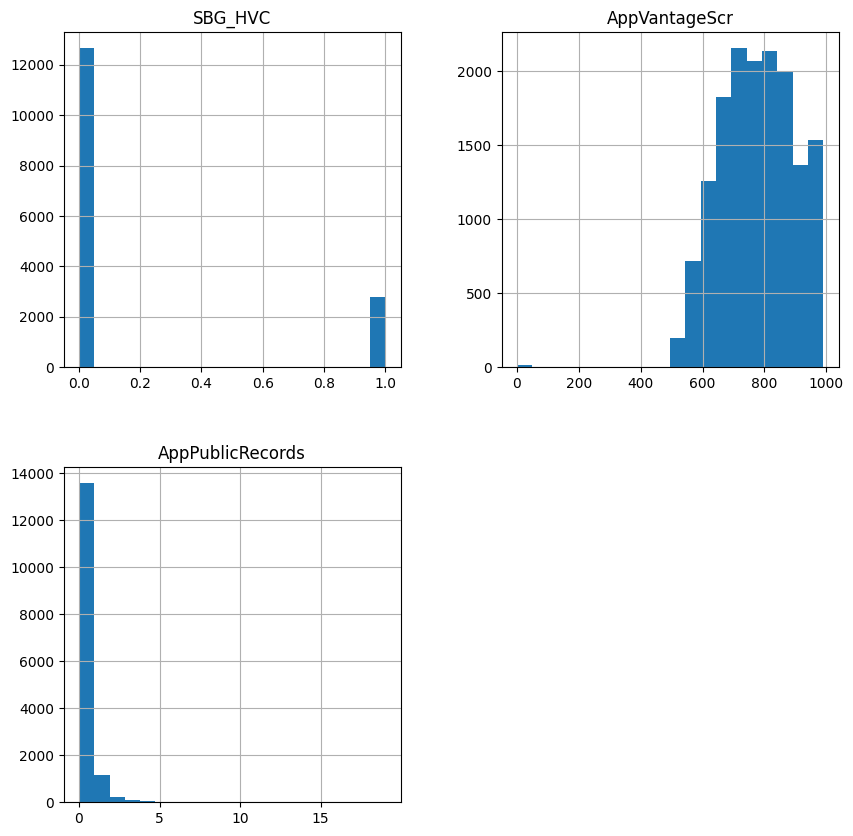

In [17]:
# checking the distribution of merchants_df columns
merchants_df[['SBG_HVC','AppVantageScr','AppPublicRecords']].hist(bins = 20 , figsize= (10,10))

In [18]:
# AppAmountPastDue
merchants_df['AppAmountPastDue'].value_counts()

,count
AppAmountPastDue,
0.0,11808
25.0,14
50.0,12
30.0,8
150.0,7
...,...
1664.0,1
10847.0,1
26855.0,1


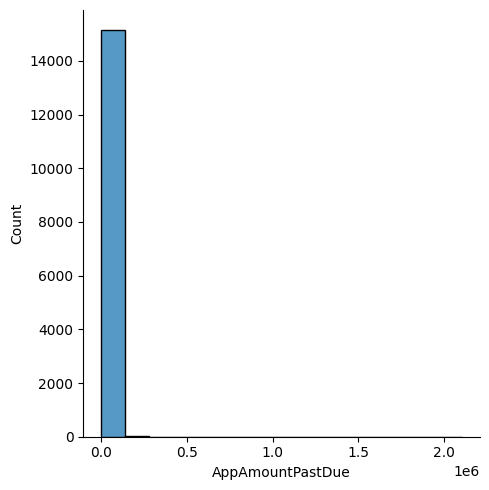

In [19]:
# checking the distribution of "AppAmountPastDue"
sns.displot(merchants_df['AppAmountPastDue'])
plt.show()

transaction df

In [20]:
# PaymentChannel
transaction_df['PaymentChannel'].value_counts()

,count
PaymentChannel,
Credit_Card,93611
ACH,29471


array([[<Axes: title={'center': 'SaleCt'}>,
        <Axes: title={'center': 'SalesAmt'}>],
       [<Axes: title={'center': 'deposit_risk_score'}>,
        <Axes: title={'center': 'PriorityScrV1'}>],
       [<Axes: title={'center': 'FinancialScoreV2'}>,
        <Axes: title={'center': 'Age'}>]], dtype=object)

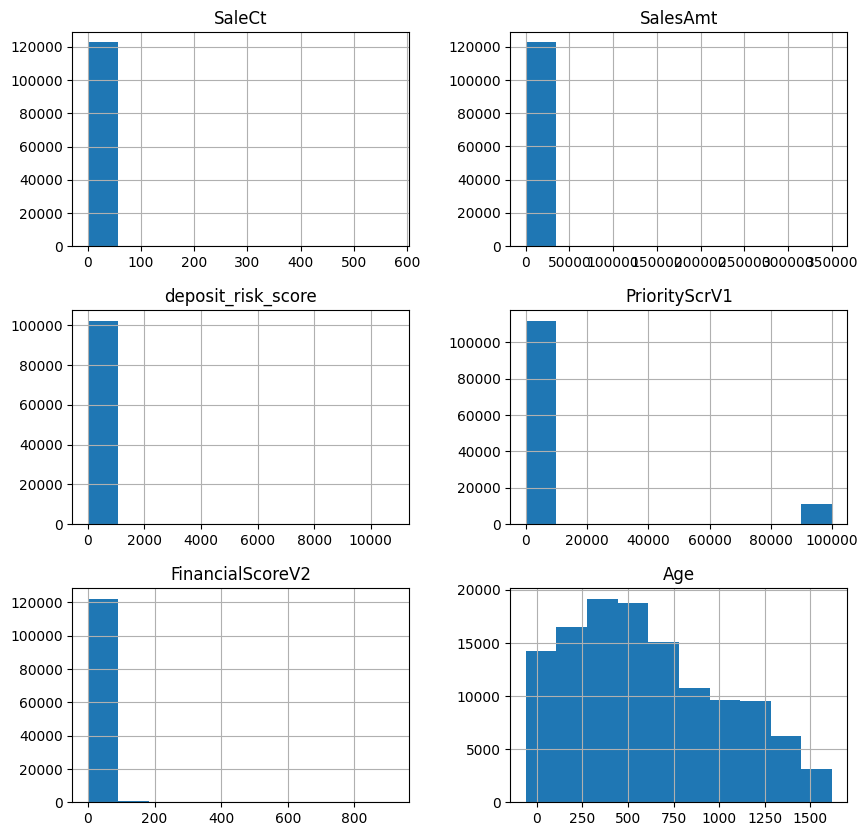

In [21]:
# checking the distribution of transaction_df columns
transaction_df[['SaleCt','SalesAmt','deposit_risk_score','PriorityScrV1','FinancialScoreV2','Age']].hist(bins = 10 , figsize= (10,10))

In [22]:
# SaleCt
transaction_df['SaleCt'].value_counts()

,count
SaleCt,
1.0,75526
2.0,21791
3.0,9084
4.0,4898
5.0,2991
...,...
211.0,1
274.0,1
281.0,1


In [23]:
# Define 'is_risky' based on ChargebackFinalAmt or ACHRtrnAmt
transaction_df['is_risky'] = ((transaction_df['ChargebackFinalAmt'].notna()) | (transaction_df['ACHRtrnAmt'].notna())).astype(int)

# Display the first few rows with the new column
transaction_df.head()

,SimuID,PaymentChannel,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky
0,258132,Credit_Card,2.0,698.66,326.560330,237,10.1593,2,NaN,NaN,6/15/2018,0
1,235650,Credit_Card,1.0,1000.00,2.860286,99999,85.0034,1157,NaN,NaN,5/19/2018,0
2,241608,ACH,2.0,622.00,0.000000,76,2.3248,6,NaN,NaN,6/11/2018,0
3,271779,Credit_Card,2.0,500.00,6.754413,6,113.7732,690,NaN,NaN,6/11/2018,0
4,261441,Credit_Card,1.0,850.00,NaN,8,-1.0000,307,NaN,NaN,5/29/2018,0


In [24]:
# Display the count of risky vs non-risky batches
transaction_df['is_risky'].value_counts()

,count
is_risky,
0,122405
1,677


In [25]:
# Aggregate transaction data to the merchant level
merchant_agg_df = transaction_df.groupby('SimuID').agg(
    total_sales_amount=('SalesAmt', 'sum'),
    total_sale_count=('SaleCt', 'sum'),
    average_sales_amount=('SalesAmt', 'mean'),
    total_chargeback_amount=('ChargebackFinalAmt', 'sum'),
    total_ach_return_amount=('ACHRtrnAmt', 'sum'),
    total_risky_batches=('is_risky', 'sum'),
    transaction_count=('SimuID', 'count'),
    risky_transaction_count=('is_risky', lambda x: (x > 0).sum()) # Count of transactions where is_risky is 1
).reset_index()

# Merge aggregated features into merchants_df
merchants_df = pd.merge(merchants_df, merchant_agg_df, on='SimuID', how='left')

# Display the first few rows of the updated merchants_df
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,3/5/2018,9000.00,4.0,3000.000000,0.0,0.0,0,3,0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,3/23/2016,3292.50,14.0,299.318182,0.0,0.0,0,11,0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,6/20/2017,20420.41,50.0,729.300357,0.0,0.0,0,28,0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,9/28/2016,17502.88,2.0,8751.440000,0.0,0.0,0,2,0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,12/3/2017,4304.60,7.0,717.433333,0.0,0.0,0,6,0


In [26]:
# Check for missing values in merchants_df
print("Missing values in merchants_df:")
display(merchants_df.isnull().sum())

# Check for missing values in transaction_df
print("\nMissing values in transaction_df:")
display(transaction_df.isnull().sum())

Missing values in merchants_df:


,0
SimuID,0
MCC,0
MCCDescription,0
Product,0
SBG_HVC,0
AppVantageScr,160
AppPublicRecords,268
AppCollections,160
AppAmountPastDue,268
AccountOpenDate,0



Missing values in transaction_df:


,0
SimuID,0
PaymentChannel,0
SaleCt,265
SalesAmt,265
deposit_risk_score,20698
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,122670
ACHRtrnAmt,122817


In [27]:
# Drop rows with missing values in specified columns from merchants_df
merchants_df.dropna(subset=['AppVantageScr', 'AppPublicRecords', 'AppCollections', 'AppAmountPastDue'], inplace=True)

# Drop rows with missing values in specified columns from transaction_df
transaction_df.dropna(subset=['SaleCt', 'SalesAmt'], inplace=True)

# Check for missing values again to confirm removal
print("Missing values in merchants_df after dropping:")
display(merchants_df.isnull().sum())

print("\nMissing values in transaction_df after dropping:")
display(transaction_df.isnull().sum())

Missing values in merchants_df after dropping:


,0
SimuID,0
MCC,0
MCCDescription,0
Product,0
SBG_HVC,0
AppVantageScr,0
AppPublicRecords,0
AppCollections,0
AppAmountPastDue,0
AccountOpenDate,0



Missing values in transaction_df after dropping:


,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,20654
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,122405
ACHRtrnAmt,122553


In [28]:
# Fill missing values in ChargebackFinalAmt and ACHRtrnAmt with 0
transaction_df['ChargebackFinalAmt'].fillna(0, inplace=True)
transaction_df['ACHRtrnAmt'].fillna(0, inplace=True)

# Check for missing values again to see the status of deposit_risk_score
print("Missing values in transaction_df after filling ChargebackFinalAmt and ACHRtrnAmt:")
display(transaction_df.isnull().sum())

Missing values in transaction_df after filling ChargebackFinalAmt and ACHRtrnAmt:


,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,20654
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [29]:
# Impute missing values in deposit_risk_score with -999
transaction_df['deposit_risk_score'].fillna(-999, inplace=True)

# Check for missing values again to confirm all have been handled
print("Missing values in transaction_df after imputing deposit_risk_score:")
display(transaction_df.isnull().sum())

Missing values in transaction_df after imputing deposit_risk_score:


,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [30]:
# Count the occurrences of -1 in FinancialScoreV2
financial_score_invalid_count = (transaction_df['FinancialScoreV2'] == -1).sum()
print(f"Number of invalid values (-1) in FinancialScoreV2: {financial_score_invalid_count}")

# Count the occurrences of 99999 in PriorityScrV1
priority_score_invalid_count = (transaction_df['PriorityScrV1'] == 99999).sum()
print(f"Number of invalid values (99999) in PriorityScrV1: {priority_score_invalid_count}")

Number of invalid values (-1) in FinancialScoreV2: 9269
Number of invalid values (99999) in PriorityScrV1: 11065


In [31]:
import numpy as np

# Replace -1 in FinancialScoreV2 with NaN
transaction_df['FinancialScoreV2'].replace(-1, np.nan, inplace=True)

# Replace 99999 in PriorityScrV1 with NaN
transaction_df['PriorityScrV1'].replace(99999, np.nan, inplace=True)

# Now impute the newly created NaNs with -999
transaction_df['FinancialScoreV2'].fillna(-999, inplace=True)
transaction_df['PriorityScrV1'].fillna(-999, inplace=True)

# Check for missing values again to confirm
print("Missing values in transaction_df after handling special values:")
display(transaction_df.isnull().sum())

Missing values in transaction_df after handling special values:


,0
SimuID,0
PaymentChannel,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0


In [32]:
transaction_df.shape

(122817, 12)

In [33]:
merchants_df.shape

(15142, 18)

In [34]:
# Calculate historical chargeback rate per merchant
merchants_df['chargeback_rate'] = merchants_df['total_chargeback_amount'] / merchants_df['total_sales_amount']
# Handle cases where total_sales_amount is zero to avoid division by zero
merchants_df['chargeback_rate'].fillna(0, inplace=True)
merchants_df.loc[merchants_df['total_sales_amount'] == 0, 'chargeback_rate'] = 0


# Calculate historical ACH return rate per merchant
merchants_df['ach_return_rate'] = merchants_df['total_ach_return_amount'] / merchants_df['total_sales_amount']
# Handle cases where total_sales_amount is zero to avoid division by zero
merchants_df['ach_return_rate'].fillna(0, inplace=True)
merchants_df.loc[merchants_df['total_sales_amount'] == 0, 'ach_return_rate'] = 0


# Calculate recency of last risky batch (in days)
# Convert 'Batch_Clear_Date' to datetime in both dataframes
transaction_df['Batch_Clear_Date'] = pd.to_datetime(transaction_df['Batch_Clear_Date'])
merchants_df['AccountOpenDate'] = pd.to_datetime(merchants_df['AccountOpenDate'])

# Find the latest batch clear date for each merchant
latest_batch_date = transaction_df.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
latest_batch_date.rename(columns={'Batch_Clear_Date': 'latest_batch_clear_date'}, inplace=True)

# Merge the latest batch clear date into merchants_df
merchants_df = pd.merge(merchants_df, latest_batch_date, on='SimuID', how='left')

# For merchants with no transactions, the latest_batch_clear_date will be NaN
# We can use their AccountOpenDate as a reference point, or impute based on the dataset's timeframe
# For simplicity, let's assume the latest date in the dataset is "today" and calculate recency from there for merchants with transactions
# For merchants with no transactions, recency could be calculated from their account open date to the latest date in the dataset

latest_date_in_dataset = transaction_df['Batch_Clear_Date'].max()

# Calculate recency for merchants with transactions
merchants_df['recency_last_batch'] = (latest_date_in_dataset - merchants_df['latest_batch_clear_date']).dt.days

# For merchants with no transactions (where latest_batch_clear_date is NaN), calculate recency from account open date
merchants_df['recency_last_batch'].fillna((latest_date_in_dataset - merchants_df['AccountOpenDate']).dt.days, inplace=True)


# You might also want a feature for recency of the LAST *risky* batch
risky_batches = transaction_df[transaction_df['is_risky'] == 1]
last_risky_batch_date = risky_batches.groupby('SimuID')['Batch_Clear_Date'].max().reset_index()
last_risky_batch_date.rename(columns={'Batch_Clear_Date': 'last_risky_batch_date'}, inplace=True)

# Merge the last risky batch date into merchants_df
merchants_df = pd.merge(merchants_df, last_risky_batch_date, on='SimuID', how='left')

# Calculate recency of last risky batch
merchants_df['recency_last_risky_batch'] = (latest_date_in_dataset - merchants_df['last_risky_batch_date']).dt.days

# For merchants with no risky batches, recency_last_risky_batch will be NaN.
# We can impute this with a value indicating no risky batches have occurred,
# such as a value larger than the maximum possible recency, or -1.
# Let's impute with a value indicating no risky batches. A large number like 9999 could work.
merchants_df['recency_last_risky_batch'].fillna(9999, inplace=True)


# Display the first few rows with the new features
merchants_df.head()

,SimuID,MCC,MCCDescription,Product,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch
0,230006,7011,"Lodging - Hotels, Motels, Resorts, Central Res...",QBMS for QBO,0,961.0,0.0,0.0,0.0,2018-03-05,9000.00,4.0,3000.000000,0.0,0.0,0,3,0,0.0,0.0,2018-06-28,2,NaT,9999.0
1,230008,5977,Cosmetic Stores,QBMS for QBO,1,917.0,0.0,0.0,0.0,2016-03-23,3292.50,14.0,299.318182,0.0,0.0,0,11,0,0.0,0.0,2018-06-18,12,NaT,9999.0
2,230013,5815,"Digital Goods-Media: Books, Movies, Music",QBMS for QBO,0,596.0,0.0,0.0,2063.0,2017-06-20,20420.41,50.0,729.300357,0.0,0.0,0,28,0,0.0,0.0,2018-06-29,1,NaT,9999.0
3,230016,8999,Professional Services not elsewhere classified,QBMS for QBO,1,864.0,0.0,0.0,0.0,2016-09-28,17502.88,2.0,8751.440000,0.0,0.0,0,2,0,0.0,0.0,2018-06-12,18,NaT,9999.0
4,230017,7372,"Computer Programming, Integrated Systems Desig...",QBMS for QBO,0,812.0,0.0,0.0,0.0,2017-12-03,4304.60,7.0,717.433333,0.0,0.0,0,6,0,0.0,0.0,2018-06-23,7,NaT,9999.0


In [35]:
merchants_df.drop('MCCDescription', axis=1, inplace=True)

In [36]:
# One-hot encode the 'Product' column in merchants_df and convert to int
merchants_df = pd.get_dummies(merchants_df, columns=['Product'], drop_first=True).astype(int)

# One-hot encode the 'PaymentChannel' column in transaction_df and convert to int
transaction_df = pd.get_dummies(transaction_df, columns=['PaymentChannel'], drop_first=True).astype(int)

print("Merchants_df after encoding Product (as int):")
display(merchants_df.head())

print("\nTransaction_df after encoding PaymentChannel (as int):")
display(transaction_df.head())

Merchants_df after encoding Product (as int):


,SimuID,MCC,SBG_HVC,AppVantageScr,AppPublicRecords,AppCollections,AppAmountPastDue,AccountOpenDate,total_sales_amount,total_sale_count,average_sales_amount,total_chargeback_amount,total_ach_return_amount,total_risky_batches,transaction_count,risky_transaction_count,chargeback_rate,ach_return_rate,latest_batch_clear_date,recency_last_batch,last_risky_batch_date,recency_last_risky_batch,Product_GoPayment Free,Product_QBMS for QBO
0,230006,7011,0,961,0,0,0,1520208000000000000,9000,4,3000,0,0,0,3,0,0,0,1530144000000000000,2,-9223372036854775808,9999,0,1
1,230008,5977,1,917,0,0,0,1458691200000000000,3292,14,299,0,0,0,11,0,0,0,1529280000000000000,12,-9223372036854775808,9999,0,1
2,230013,5815,0,596,0,0,2063,1497916800000000000,20420,50,729,0,0,0,28,0,0,0,1530230400000000000,1,-9223372036854775808,9999,0,1
3,230016,8999,1,864,0,0,0,1475020800000000000,17502,2,8751,0,0,0,2,0,0,0,1528761600000000000,18,-9223372036854775808,9999,0,1
4,230017,7372,0,812,0,0,0,1512259200000000000,4304,7,717,0,0,0,6,0,0,0,1529712000000000000,7,-9223372036854775808,9999,0,1



Transaction_df after encoding PaymentChannel (as int):


,SimuID,SaleCt,SalesAmt,deposit_risk_score,PriorityScrV1,FinancialScoreV2,Age,ChargebackFinalAmt,ACHRtrnAmt,Batch_Clear_Date,is_risky,PaymentChannel_Credit_Card
0,258132,2,698,326,237,10,2,0,0,1529020800000000000,0,1
1,235650,1,1000,2,-999,85,1157,0,0,1526688000000000000,0,1
2,241608,2,622,0,76,2,6,0,0,1528675200000000000,0,0
3,271779,2,500,6,6,113,690,0,0,1528675200000000000,0,1
4,261441,1,850,-999,8,-999,307,0,0,1527552000000000000,0,1


In [37]:
# Select numerical features for correlation analysis
numerical_features = merchants_df.select_dtypes(include=np.number).columns.tolist()
# Add the target variable if it's not already included (it's in transaction_df, so we'll need to be careful)
# For now, let's focus on features in merchants_df and their potential relationship with merchant-level risk indicators we created

# Let's merge merchants_df and transaction_df on SimuID to have features and target in one df for correlation analysis
# We need to decide at what level to analyze risk - merchant or batch.
# Our goal is to identify risky *batches*, so we should ideally correlate features (merchant and batch level) with the batch-level 'is_risky'

# Let's merge merchants_df features to transaction_df for a combined view
# Need to make sure the index is aligned or merge on SimuID

# First, let's ensure merchants_df is ready for merging (handle dates and SimuID as index?)
# merchants_df['SimuID'] = merchants_df['SimuID'].astype(int)
# transaction_df['SimuID'] = transaction_df['SimuID'].astype(int)

# Drop date columns and MCCDescription before calculating correlations
merchants_for_corr = merchants_df.drop(columns=['AccountOpenDate', 'latest_batch_clear_date', 'last_risky_batch_date'])
transaction_for_corr = transaction_df.drop(columns=['Batch_Clear_Date'])


# Merge the dataframes on SimuID
# We need to decide how to handle the many-to-one relationship (multiple transactions per merchant)
# Option 1: Analyze correlations at the batch level by merging merchant features to every transaction
# Option 2: Analyze correlations at the merchant level (correlating merchant features with total_risky_batches or risky_transaction_count per merchant)

# Since our target is batch-level risk ('is_risky' in transaction_df), let's go with Option 1 for correlation analysis
merged_df_for_corr = pd.merge(transaction_for_corr, merchants_for_corr, on='SimuID', how='left')

# Calculate the correlation matrix
correlation_matrix = merged_df_for_corr.corr()

# Display correlations with the target variable 'is_risky'
print("Correlations with 'is_risky':")
display(correlation_matrix['is_risky'].sort_values(ascending=False))

Correlations with 'is_risky':


,is_risky
is_risky,1.000000
ChargebackFinalAmt,0.298648
ACHRtrnAmt,0.288558
risky_transaction_count,0.276972
total_risky_batches,0.276972
total_chargeback_amount,0.153435
chargeback_rate,0.109382
total_ach_return_amount,0.082099
SaleCt,0.075946
ach_return_rate,0.038671


In [38]:
# Impute remaining NaNs in merged_df_for_corr with 0
merged_df_for_corr.fillna(0, inplace=True)

# Verify that there are no more missing values
print("Missing values in merged_df_for_corr after imputation:")
display(merged_df_for_corr.isnull().sum())

Missing values in merged_df_for_corr after imputation:


,0
SimuID,0
SaleCt,0
SalesAmt,0
deposit_risk_score,0
PriorityScrV1,0
FinancialScoreV2,0
Age,0
ChargebackFinalAmt,0
ACHRtrnAmt,0
is_risky,0


In [39]:
# Define the target variable
y = transaction_df['is_risky']

# Define the features (X)
# Exclude SimuID, original risk outcome columns, original categorical columns, and the missingness indicator
columns_to_drop = ['SimuID', 'ChargebackFinalAmt', 'ACHRtrnAmt', 'is_risky',
                   'MCC', 'MCCDescription', 'deposit_risk_score_missing']

# Drop the columns from merged_df_for_corr, ignoring errors for columns not found
X = merged_df_for_corr.drop(columns=columns_to_drop, errors='ignore')

# Also drop the original categorical columns 'Product' and 'PaymentChannel' if they exist and weren't dropped already
X = X.drop(columns=['Product', 'PaymentChannel'], errors='ignore')


print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (122817, 26)
Shape of y: (122817,)


In [40]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (92112, 26)
Shape of X_test: (30705, 26)
Shape of y_train: (92112,)
Shape of y_test: (30705,)


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize and train the Logistic Regression model
# We can use class_weight='balanced' to help address the class imbalance
logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test)
y_pred_proba_logistic = logistic_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

In [42]:
# Evaluate the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba_logistic)
print(f"\nROC AUC Score: {roc_auc}")

Logistic Regression Model Evaluation:
Confusion Matrix:
[[27937  2599]
 [    1   168]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96     30536
           1       0.06      0.99      0.11       169

    accuracy                           0.92     30705
   macro avg       0.53      0.95      0.53     30705
weighted avg       0.99      0.92      0.95     30705


ROC AUC Score: 0.9705372492725629


In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Define the parameter distribution for Randomized Search for Logistic Regression
param_dist_lr = {
    'C': uniform(0.01, 100),  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'], # Solvers
    'class_weight': ['balanced', None] # Class weight options
}

# Initialize the Logistic Regression model with fixed random state
lr_model = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_lr = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for Logistic Regression: ", random_search_lr.best_params_)
print("Best ROC AUC score for Logistic Regression: ", random_search_lr.best_score_)

# Get the best Logistic Regression model
best_lr_model = random_search_lr.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found for Logistic Regression:  {'C': np.float64(14.102422497476264), 'class_weight': 'balanced', 'solver': 'liblinear'}
Best ROC AUC score for Logistic Regression:  0.976840363937138


In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lr = best_lr_model.predict(X_test)
y_pred_proba_best_lr = best_lr_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best Logistic Regression model
print("Best Logistic Regression Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lr))

# Calculate ROC AUC score
roc_auc_best_lr = roc_auc_score(y_test, y_pred_proba_best_lr)
print(f"\nROC AUC Score: {roc_auc_best_lr}")

Best Logistic Regression Model Evaluation (on Test Set):
Confusion Matrix:
[[27942  2594]
 [    2   167]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     30536
           1       0.06      0.99      0.11       169

    accuracy                           0.92     30705
   macro avg       0.53      0.95      0.53     30705
weighted avg       0.99      0.92      0.95     30705


ROC AUC Score: 0.975840718802368


In [43]:
# %pip install lightgbm

In [44]:
import lightgbm as lgb

# Initialize and train the LightGBM model
# We'll use scale_pos_weight to handle class imbalance
# Calculate the scale_pos_weight
scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

lgbm_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value)
lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 507, number of negative: 91605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 92112, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005504 -> initscore=-5.196730
[LightGBM] [Info] Start training from score -5.196730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped traini

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate the LightGBM model
print("LightGBM Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Calculate ROC AUC score
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"\nROC AUC Score: {roc_auc_lgbm}")

LightGBM Model Evaluation:
Confusion Matrix:
[[26294  4242]
 [  113    56]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     30536
           1       0.01      0.33      0.03       169

    accuracy                           0.86     30705
   macro avg       0.50      0.60      0.47     30705
weighted avg       0.99      0.86      0.92     30705


ROC AUC Score: 0.5952580173096688


In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'num_leaves': randint(20, 150),         # Maximum number of leaves in one tree
    'max_depth': randint(-1, 20),           # Maximum tree depth (-1 means no limit)
    'min_child_samples': randint(5, 50),    # Minimum number of data needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the LightGBM model with fixed random state
lgbm_model = lgb.LGBMClassifier(random_state=42)

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best ROC AUC score: ", random_search.best_score_)

# Get the best model
best_lgbm_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 507, number of negative: 91605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 92112, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005504 -> initscore=-5.196730
[LightGBM] [Info] Start training from score -5.196730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_lgbm = best_lgbm_model.predict(X_test)
y_pred_proba_best_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best LightGBM model
print("Best LightGBM Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_lgbm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_lgbm))

# Calculate ROC AUC score
roc_auc_best_lgbm = roc_auc_score(y_test, y_pred_proba_best_lgbm)
print(f"\nROC AUC Score: {roc_auc_best_lgbm}")

Best LightGBM Model Evaluation (on Test Set):
Confusion Matrix:
[[28345  2191]
 [    4   165]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     30536
           1       0.07      0.98      0.13       169

    accuracy                           0.93     30705
   macro avg       0.53      0.95      0.55     30705
weighted avg       0.99      0.93      0.96     30705


ROC AUC Score: 0.9813117081322579


In [48]:
# Install XGBoost if you haven't already
%pip install xgboost

In [49]:
import xgboost as xgb

# Initialize and train the XGBoost model
# We'll use scale_pos_weight to handle class imbalance
# The scale_pos_weight value is the same as calculated for LightGBM
# scale_pos_weight_value = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_value, eval_metric='logloss') # Use logloss or AUC as eval_metric for binary classification
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate the XGBoost model
print("XGBoost Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Calculate ROC AUC score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"\nROC AUC Score: {roc_auc_xgb}")

XGBoost Model Evaluation:
Confusion Matrix:
[[30224   312]
 [  108    61]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     30536
           1       0.16      0.36      0.23       169

    accuracy                           0.99     30705
   macro avg       0.58      0.68      0.61     30705
weighted avg       0.99      0.99      0.99     30705


ROC AUC Score: 0.967672263449253


In [51]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

# Define the parameter distribution for Randomized Search for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 500),       # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.1),    # Step size shrinkage
    'max_depth': randint(3, 10),           # Maximum tree depth
    'min_child_weight': randint(1, 10),    # Minimum sum of instance weight (hessian) needed in a child
    'subsample': uniform(0.6, 0.4),         # Fraction of samples used for fitting the individual base learners
    'colsample_bytree': uniform(0.6, 0.4),  # Fraction of features used for fitting the individual base learners
    'gamma': uniform(0, 0.5),              # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),             # L1 regularization
    'reg_lambda': uniform(0, 1),            # L2 regularization
    'scale_pos_weight': [scale_pos_weight_value] # Use the calculated scale_pos_weight
}

# Initialize the XGBoost model with fixed random state
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss') # Use logloss or AUC as eval_metric

# Initialize RandomizedSearchCV
# We'll use ROC AUC as the scoring metric for tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='roc_auc', # Optimize for ROC AUC
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1   # Use all available cores
)

# Perform the randomized search
random_search_xgb.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found for XGBoost: ", random_search_xgb.best_params_)
print("Best ROC AUC score for XGBoost: ", random_search_xgb.best_score_)

# Get the best XGBoost model
best_xgb_model = random_search_xgb.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found for XGBoost:  {'colsample_bytree': np.float64(0.7996773519539009), 'gamma': np.float64(0.28600209960459155), 'learning_rate': np.float64(0.0868554014306309), 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 55, 'reg_alpha': np.float64(0.3701587002554444), 'reg_lambda': np.float64(0.015456616528867428), 'scale_pos_weight': 180.68047337278105, 'subsample': np.float64(0.9713274250350902)}
Best ROC AUC score for XGBoost:  0.9796938166148782


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Make predictions on the test set using the best model
y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

# Evaluate the best XGBoost model
print("Best XGBoost Model Evaluation (on Test Set):")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))

# Calculate ROC AUC score
roc_auc_best_xgb = roc_auc_score(y_test, y_pred_proba_best_xgb)
print(f"\nROC AUC Score: {roc_auc_best_xgb}")

Best XGBoost Model Evaluation (on Test Set):
Confusion Matrix:
[[28260  2276]
 [    3   166]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     30536
           1       0.07      0.98      0.13       169

    accuracy                           0.93     30705
   macro avg       0.53      0.95      0.54     30705
weighted avg       0.99      0.93      0.96     30705


ROC AUC Score: 0.9805873715067907


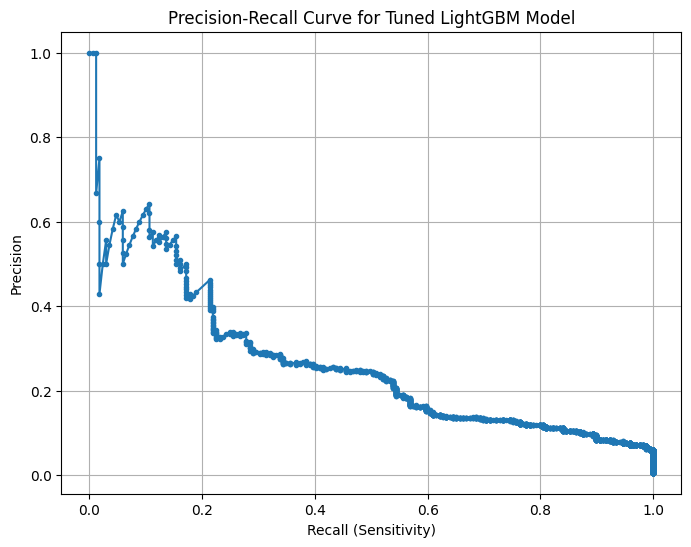


Precision and Recall at selected Thresholds:
  Recall: 0.8994, Precision: 0.0836 at Threshold: 0.8351
  Recall: 0.9527, Precision: 0.0751 at Threshold: 0.7677
  Recall: 0.9822, Precision: 0.0692 at Threshold: 0.4667


In [55]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_best_lgbm)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Tuned LightGBM Model')
plt.grid(True)
plt.show()

# Optionally, display precision and recall for a few specific thresholds
# For example, thresholds that give a certain level of recall
# Find thresholds closest to desired recall levels (e.g., 0.9, 0.95, 0.98)
# You can adjust these target_recall levels
target_recall_levels = [0.90, 0.95, 0.98]
print("\nPrecision and Recall at selected Thresholds:")
for target_recall in target_recall_levels:
    # Find the threshold that provides the closest recall
    closest_recall_idx = np.argmin(np.abs(recall - target_recall))
    threshold_at_recall = thresholds[closest_recall_idx]
    precision_at_recall = precision[closest_recall_idx]
    print(f"  Recall: {recall[closest_recall_idx]:.4f}, Precision: {precision_at_recall:.4f} at Threshold: {threshold_at_recall:.4f}")

In [56]:
# Define the chosen threshold
chosen_threshold = 0.8351

# Apply the threshold to the predicted probabilities to get binary predictions
y_pred_at_threshold = (y_pred_proba_best_lgbm >= chosen_threshold).astype(int)

# Calculate the confusion matrix at this threshold
conf_matrix_at_threshold = confusion_matrix(y_test, y_pred_at_threshold)

print(f"Confusion Matrix at Threshold {chosen_threshold}:")
print(conf_matrix_at_threshold)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_at_threshold.ravel()

print(f"\nAt a threshold of {chosen_threshold}:")
print(f"  True Positives (Risky batches correctly identified): {TP}")
print(f"  False Positives (Non-risky batches incorrectly flagged): {FP}")
print(f"  False Negatives (Risky batches missed): {FN}")
print(f"  True Negatives (Non-risky batches correctly identified): {TN}")

print(f"\n  Recall (TP / (TP + FN)): {TP / (TP + FN):.4f}")
print(f"  Precision (TP / (TP + FP)): {TP / (TP + FP):.4f}")

Confusion Matrix at Threshold 0.8351:
[[28871  1665]
 [   17   152]]

At a threshold of 0.8351:
  True Positives (Risky batches correctly identified): 152
  False Positives (Non-risky batches incorrectly flagged): 1665
  False Negatives (Risky batches missed): 17
  True Negatives (Non-risky batches correctly identified): 28871

  Recall (TP / (TP + FN)): 0.8994
  Precision (TP / (TP + FP)): 0.0837
